In [1]:
## import packages
## --------------------------------------------------------------------------------------------------

import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt

## 1. 
On considère que les équations sont en 1D et non bruitées

\begin{equation}
\frac{d V}{dt} = \alpha v - \gamma V
\end{equation}

\begin{equation}
\frac{d v}{dt} = -\beta v + \alpha V
\end{equation}

\begin{equation}
\frac{d r}{dt} = v
\end{equation}

Avec $r$ la position, $v$ la vitesse et $V$ la vitesse auxiliaire définie par,
\begin{equation}
V=\alpha \int_{-\infty}^{t} e^{\gamma (t-t')}v(t')\text{d}t'
\end{equation}

In [2]:
## define functions
## --------------------------------------------------------------------------------------------------

def coupled_ode(y, t, a, b, g):
    """
    Notations:
    r position
    v speed
    V auxiliary speed
    """
    
    r, v, V = y

    drdt=v
    dvdt=-b*v + a*V
    dVdt=a*v - g*V
    return [drdt, dvdt, dVdt]
#

In [3]:
## user interface
## --------------------------------------------------------------------------------------------------

# initial conditions
# units µm, h

y0=[0., 2., .1]    ## r0, v0, V0     

# experimental parameters (Selmeczi et al.)
a=1.5
b=4.1
g=1.

t = np.linspace(0, 10, 1000)

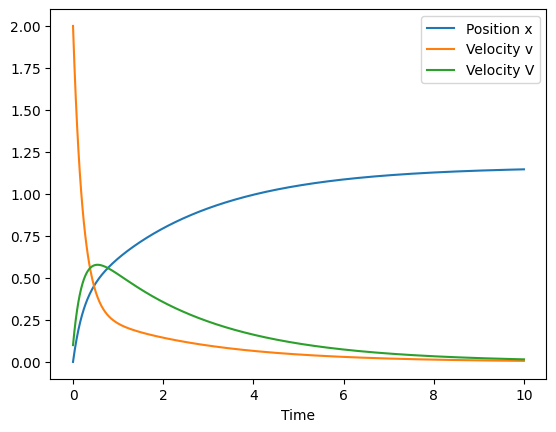

In [4]:
## main
## --------------------------------------------------------------------------------------------------

solutions = odeint(coupled_ode, y0, t, args=(a, b, g))
 
r_values = solutions[:, 0]
v_values = solutions[:, 1]
V_values = solutions[:, 2]
 
plt.plot(t, r_values, label='Position x')
plt.plot(t, v_values, label='Velocity v')
plt.plot(t, V_values, label='Velocity V')
plt.xlabel('Time')
plt.legend()
plt.show()

## 2. 
On considère que les équations sont en 1D et on ajoute du bruit

\begin{equation}
\frac{d V}{dt} = \alpha v - \gamma V
\end{equation}

\begin{equation}
\frac{d v}{dt} = -\beta v + \alpha V + (\sigma _0 +\sigma _1 v)\eta
\end{equation}

\begin{equation}
\frac{d r}{dt} = v
\end{equation}

Avec $\eta$ un bruit gaussien

In [5]:
## define functions
## --------------------------------------------------------------------------------------------------

def noisy_coupled_ode(y, t, a, b, g, s0, s1, Dt):
    """
    Notations:
    r position
    v speed
    V auxiliary speed
    """
    
    r, v, V = y

    #noise
    u1, u2=np.random.rand(2)
    eta=np.sqrt(-2.*np.log(u1)) * np.cos(2.*np.pi*u2)

    drdt=v
    dvdt=-b*v + a*V + np.sqrt(Dt)/Dt*2.*10**-4*eta #np.sqrt(Dt)/Dt*(s0+s1*v)*eta
    dVdt=a*v - g*V
    return [drdt, dvdt, dVdt]
#

In [6]:
## user interface
## --------------------------------------------------------------------------------------------------

# initial conditions
# units µm, h

y0=[0., 5., 0.]    ## r0, v0, V0     

# experimental parameters (Selmeczi et al.)
a=1.5
b=4.1
g=1.
s0=11.
s1=1.3

t = np.linspace(0., 5., 5*10**7)
Dt=(t[-1]-t[0])/(len(t)-1)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_9112\203941623.py:4: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  solutions = odeint(noisy_coupled_ode, y0, t, args=(a, b, g, s0, s1, Dt))


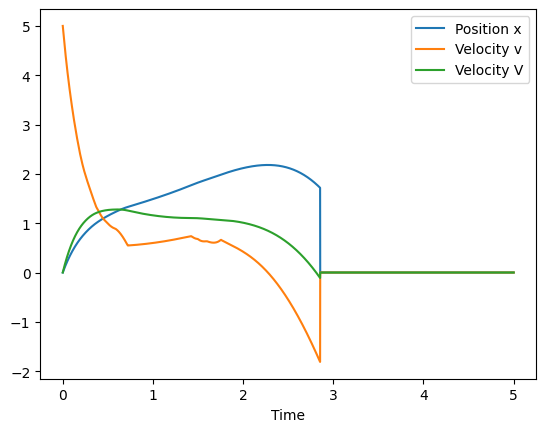

In [7]:
## main
## --------------------------------------------------------------------------------------------------

solutions = odeint(noisy_coupled_ode, y0, t, args=(a, b, g, s0, s1, Dt))
 
r_values = solutions[:, 0]
v_values = solutions[:, 1]
V_values = solutions[:, 2]
 
plt.plot(t, r_values, label='Position x')
plt.plot(t, v_values, label='Velocity v')
plt.plot(t, V_values, label='Velocity V')
plt.xlabel('Time')
plt.legend(loc="upper right")
plt.show()

### CCL utilisation de odeint pour les équations stochastiques
C'est pas fiable !
Et utiliser le terme correctif $\sqrt{\Delta t} / \Delta t$ c'est du gros bricolage

## 3. 
On essaye la même chose avec le paquet sdeint pour intégrer des équations stochastiques. Ici un exemple de la démo :


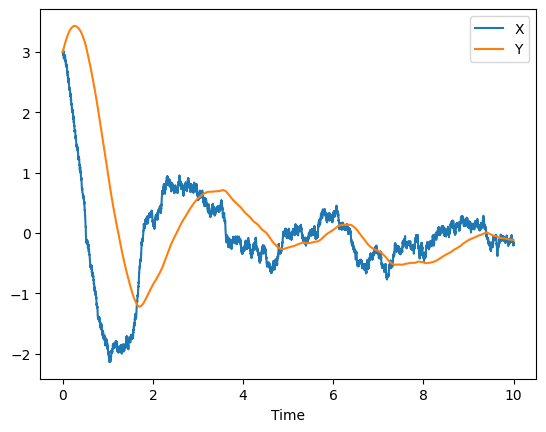

In [8]:
import sdeint

A = np.array([[-0.5, -2.0],
              [ 2.0, -1.0]])

B = np.diag([0.5, 0.]) # diagonal, so independent driving Wiener processes

tspan = np.linspace(0.0, 10.0, 10001)
x0 = np.array([3.0, 3.0])

def f(x, t):
    return A.dot(x)

def G(x, t):
    return B

result = sdeint.itoint(f, G, x0, tspan)

plt.plot(tspan, result, label=['X', 'Y'])
plt.xlabel('Time')
plt.legend(loc="upper right")
plt.show()


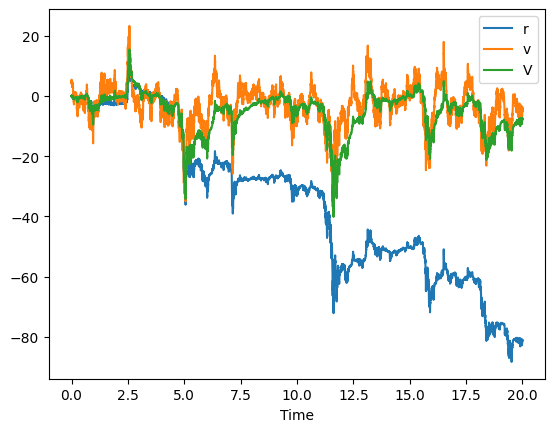

In [9]:
# experimental parameters (Selmeczi et al.)
a=1.5
b=4.1
g=1.
s0=11.    #11.
s1=1.3    #1.3

A = np.array([[0., 1., 0.],
              [0., -b, a],
              [0., a, -g]
              ])

B0 = np.diag([0., s0, 0.]) # diagonal, so independent driving Wiener processes
B1 = np.diag([0., s1, 0.])

tspan = np.linspace(0.0, 20.0, 12001)
x0 = np.array([0., 5., 0.])  ## r0, v0, V0    

def f(x, t):
    return A.dot(x)

def G(x, t):
    v=np.abs(x[1])
    return B0+B1.dot([0., v, 0.])

result = sdeint.itoint(f, G, x0, tspan)

plt.plot(tspan, result, label=['r', 'v', 'V'])
plt.xlabel('Time')
plt.legend(loc="upper right")
plt.show()


On impose $\Delta t_{exp}=10$ min et on choisit un pas d'intégration de $\Delta t_{int}=\Delta t_{exp}/100$. Le nombre de points $N_p$ à donner à la fonction $linspace$ est donc donné par $\Delta t_{int} (N_p-1) = T$, avec $T=20$ h le temps de simulation.

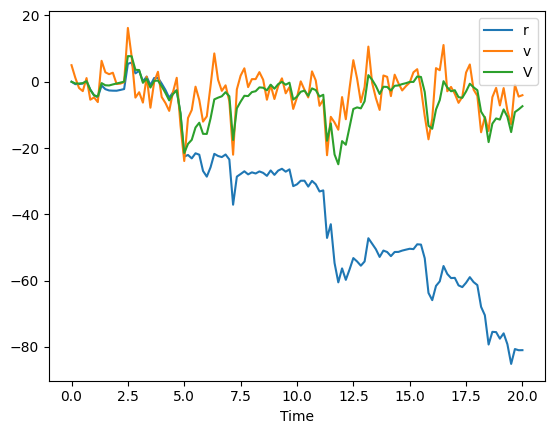

In [10]:
n=100

#sub sampling
result_sampled=result[::n]
tspan_sampled=tspan[::n]

plt.plot(tspan_sampled, result_sampled, label=['r', 'v', 'V'])
plt.xlabel('Time')
plt.legend(loc="upper right")
plt.show()